In [1]:
from helper import *

# Device detection and setup
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
if torch.cuda.is_available():
    print(f"CUDA device: {torch.cuda.get_device_name(0)}")
    print(f"CUDA memory: {torch.cuda.get_device_properties(0).total_memory / 1024**3:.1f} GB")

set_seed = 17

Using device: cuda
CUDA device: NVIDIA GeForce RTX 4060 Ti
CUDA memory: 16.0 GB


In [2]:
# RGB to HSV Network
class RGBtoHSVNet(nn.Module):
    def __init__(self):
        super(RGBtoHSVNet, self).__init__()
        self.fc1 = nn.Linear(3, 64)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(64, 64)
        self.relu2 = nn.ReLU()
        self.fc3 = nn.Linear(64, 3)
        
    def forward(self, x):
        x = self.relu1(self.fc1(x))
        x = self.relu2(self.fc2(x))
        x = self.fc3(x)
        return x

In [19]:
# RGB-HSV Dataset
rgb_train = generate_rgb_samples(1000, device=device, seed=42)
hsv_train = rgb_to_hsv(rgb_train)

rgb_test = generate_rgb_samples(250, device=device, seed=123)
hsv_test = rgb_to_hsv(rgb_test)

rgb_train_loader = DataLoader(TensorDataset(rgb_train.cpu(), hsv_train.cpu()), batch_size=32, shuffle=False)
rgb_test_loader = DataLoader(TensorDataset(rgb_test.cpu(), hsv_test.cpu()), batch_size=32, shuffle=False)

# Example usage (deterministic training):
rgb_model = RGBtoHSVNet()
rgb_criterion = nn.MSELoss()
rgb_optimizer = optim.Adam(rgb_model.parameters(), lr=0.001)
rgb_losses, trained_rgb = train_model(rgb_model, rgb_train_loader, rgb_criterion, rgb_optimizer, num_epochs=100, seed=42, verbose=True)

All seeds set to: 42
Model weights initialized with seed: 42
Training on device: cuda
Epoch [20/100], Loss: 0.005751
Epoch [40/100], Loss: 0.002921
Epoch [60/100], Loss: 0.001910
Epoch [80/100], Loss: 0.001440
Epoch [100/100], Loss: 0.001160


In [4]:
# Show specific samples:
show_rgb_hsv_samples(rgb_test.cpu(), hsv_test.cpu(), indices=0)  # Single index

RGB to HSV Conversion Samples:
------------------------------------------------------------
Index  RGB                  HSV                 
------------------------------------------------------------
0      (0.067, 0.945, 0.221) (0.363, 0.929, 0.945)


In [5]:
# RGB
index = 0
predictions_rgb, sample_targets_rgb, sample_inputs_rgb = predict_and_show(trained_rgb, rgb_test_loader, dataset_type='rgb_hsv', indices=index)
print(f"\nMSE Loss: {nn.MSELoss()(predictions_rgb, sample_targets_rgb).item():.8f}")

RGB to HSV Predictions:
------------------------------------------------------------------------------------------
Index  Input RGB            True HSV             Pred HSV            
------------------------------------------------------------------------------------------
0      (0.067, 0.945, 0.221) (0.363, 0.929, 0.945) (0.364, 0.921, 0.937)

MSE Loss: 0.00004530


In [6]:
# Full Network capture
rgb_inputs, rgb_activations, rgb_outputs = get_activations(trained_rgb, rgb_train_loader, dataset_type='rgb_hsv')

# Single Sample capture
single_rgb_inputs, single_rgb_activations, single_rgb_outputs = get_activations(trained_rgb, rgb_test_loader, dataset_type='rgb_hsv', indices=index)

In [7]:
# Finding KNN - L2
indices_rgb, distances_rgb = find_knn(rgb_activations, single_rgb_activations, k=1, metric='l2')
print(f"KNN Indices (L2): {indices_rgb}")
print(f"KNN Distances (L2): {distances_rgb}")

KNN Indices (L2): tensor([640])
KNN Distances (L2): tensor([0.2345])


In [8]:
filtered_rgb_loader, filtered_size = create_filtered_dataloader(rgb_train_loader, exclude_indices=indices_rgb, batch_size=64, shuffle=False)

In [9]:
filtered_rgb_model = RGBtoHSVNet()
rgb_criterion = nn.MSELoss()
rgb_optimizer = optim.Adam(filtered_rgb_model.parameters(), lr=0.001)
rgb_losses, filtered_rgb = train_model(filtered_rgb_model, filtered_rgb_loader, rgb_criterion, rgb_optimizer, num_epochs=100, seed=42, verbose=True)

All seeds set to: 42
Model weights initialized with seed: 42
Training on device: cuda
Epoch [20/100], Loss: 0.008904
Epoch [40/100], Loss: 0.005061
Epoch [60/100], Loss: 0.003238
Epoch [80/100], Loss: 0.002351
Epoch [100/100], Loss: 0.001840


In [10]:
# Base model prediction
predictions_base_rgb, sample_targets_rgb, sample_inputs_rgb = predict_and_show(trained_rgb, rgb_test_loader, dataset_type='rgb_hsv', indices=index)

# Filtered Model prediction
predictions_filtered_rgb, sample_targets_rgb, sample_inputs_rgb = predict_and_show(filtered_rgb, rgb_test_loader, dataset_type='rgb_hsv', indices=index)

RGB to HSV Predictions:
------------------------------------------------------------------------------------------
Index  Input RGB            True HSV             Pred HSV            
------------------------------------------------------------------------------------------
0      (0.067, 0.945, 0.221) (0.363, 0.929, 0.945) (0.364, 0.921, 0.937)
RGB to HSV Predictions:
------------------------------------------------------------------------------------------
Index  Input RGB            True HSV             Pred HSV            
------------------------------------------------------------------------------------------
0      (0.067, 0.945, 0.221) (0.363, 0.929, 0.945) (0.347, 0.884, 0.948)


In [11]:
base_mse = nn.MSELoss()(predictions_base_rgb, sample_targets_rgb).item()
print(f"{base_mse:.8f}")
print(f"{nn.MSELoss()(predictions_filtered_rgb, sample_targets_rgb).item():.8f}")

0.00004530
0.00076141


In [12]:
# base          0.00017240
# 1 Sample      0.00054405
# 100 Sample    0.00519412

In [13]:
list_of_k = list(range(1, 101, 10))
#list_of_k = [1, 5, 10, 50, 100, 250]

list_of_indices = [0,1,2,3,4,5,6,7,8,9]

In [14]:
# Function to calculate MSE loss for different k and indices
def calculate_mse_for_k_and_indices(model, train_loader, test_loader, list_of_k, list_of_indices):
    mse_results = {
        'closest_mse': {},
        'last_mse': {},
        'random_mse': {}
    }

    for k in list_of_k:
        mse_results['closest_mse'][k] = []
        mse_results['last_mse'][k] = []
        mse_results['random_mse'][k] = []

        for index in list_of_indices:

            # Get activations for the single sample
            single_inputs, single_activations, _ = get_activations(model, test_loader, dataset_type='rgb_hsv', indices=index)

            # Find k-nearest neighbors for the entire dataset
            indices_knn, _ = find_knn(rgb_activations, single_activations, k=len(rgb_activations), metric='l2')

            # Closest k neighbors
            closest_indices = indices_knn[:k]
            # Last in the list
            last_indices = indices_knn[-k:]
            # Random indices
            random_indices = np.random.choice(indices_knn, k, replace=False)

            for subset_name, subset_indices in zip(['closest_mse', 'last_mse', 'random_mse'], [closest_indices, last_indices, random_indices]):

                # Create filtered dataloader
                filtered_loader, _ = create_filtered_dataloader(train_loader, exclude_indices=subset_indices, batch_size=64, shuffle=False)

                # Train a new model completely with the filtered dataset
                filtered_model = RGBtoHSVNet()
                optimizer_tmp = optim.Adam(filtered_model.parameters(), lr=0.001)
                criterion = nn.MSELoss()
                train_model(filtered_model, filtered_loader, criterion, optimizer_tmp, num_epochs=50, seed=42, verbose=False)

                # Predict and calculate MSE loss
                predictions, targets, _ = predict_and_show(filtered_model, test_loader, dataset_type='rgb_hsv', indices=index)
                mse_loss = nn.MSELoss()(predictions, targets).item()
                mse_results[subset_name][k].append(mse_loss)

    return mse_results

In [15]:
# Example usage of the loop and visualization
mse_results = calculate_mse_for_k_and_indices(trained_rgb, rgb_train_loader, rgb_test_loader, list_of_k, list_of_indices)
# visualize_mse_results(mse_results, list_of_indices, selected_index=0)  # Visualize for a specific index
# visualize_mse_results(mse_results, list_of_indices, average=True)  # Visualize averaged results

All seeds set to: 42
Model weights initialized with seed: 42
RGB to HSV Predictions:
------------------------------------------------------------------------------------------
Index  Input RGB            True HSV             Pred HSV            
------------------------------------------------------------------------------------------
0      (0.067, 0.945, 0.221) (0.363, 0.929, 0.945) (0.350, 0.886, 0.941)
All seeds set to: 42
Model weights initialized with seed: 42
RGB to HSV Predictions:
------------------------------------------------------------------------------------------
Index  Input RGB            True HSV             Pred HSV            
------------------------------------------------------------------------------------------
0      (0.067, 0.945, 0.221) (0.363, 0.929, 0.945) (0.340, 0.898, 0.943)
All seeds set to: 42
Model weights initialized with seed: 42
RGB to HSV Predictions:
------------------------------------------------------------------------------------------
Inde

RGB to HSV Predictions:
------------------------------------------------------------------------------------------
Index  Input RGB            True HSV             Pred HSV            
------------------------------------------------------------------------------------------
0      (0.067, 0.945, 0.221) (0.363, 0.929, 0.945) (0.364, 0.921, 0.937)


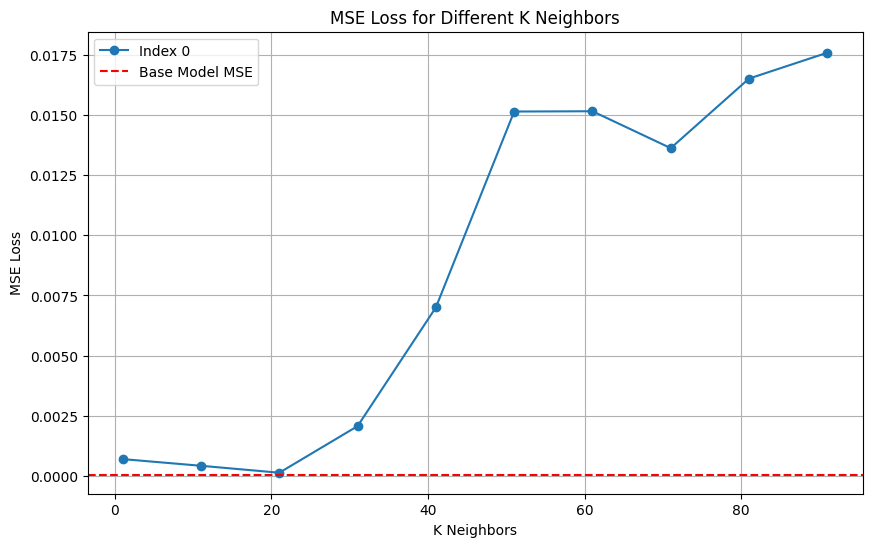

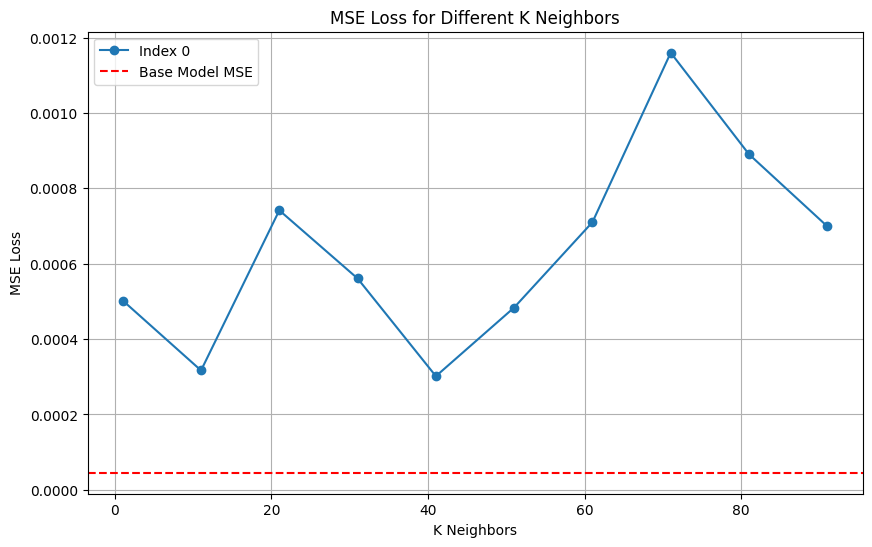

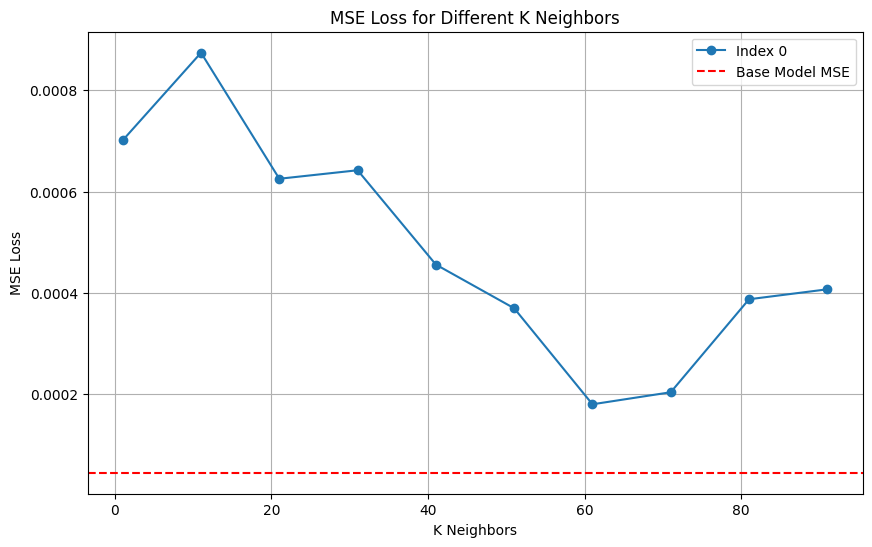

In [24]:
index_base = 0

predictions_tmp, sample_targets_rgb, _ = predict_and_show(trained_rgb, rgb_test_loader, dataset_type='rgb_hsv', indices=index_base)
base_mse =nn.MSELoss()(predictions_tmp, sample_targets_rgb).item()

visualize_mse_results(mse_results['closest_mse'], list_of_indices, selected_index=index_base, base_mse=base_mse)  # Visualize for a specific index
visualize_mse_results(mse_results['last_mse'], list_of_indices, selected_index=index_base, base_mse=base_mse)  # Visualize for a specific index
visualize_mse_results(mse_results['random_mse'], list_of_indices, selected_index=index_base, base_mse=base_mse)  # Visualize for a specific index

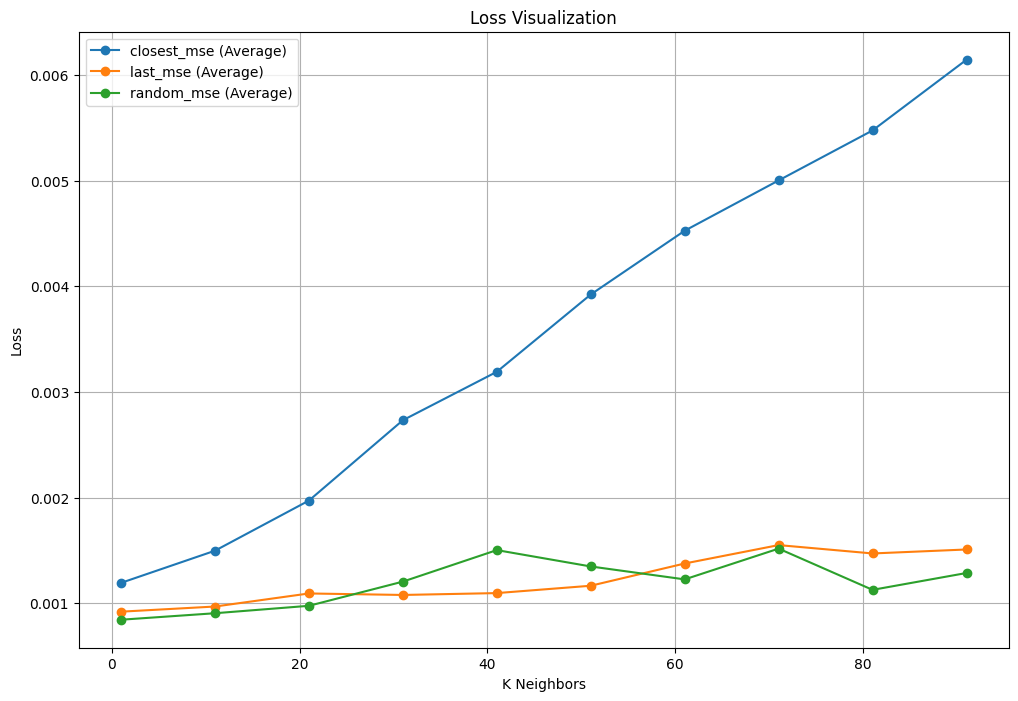

In [25]:
visualize_results(mse_results, list_of_indices, average=True)

closest


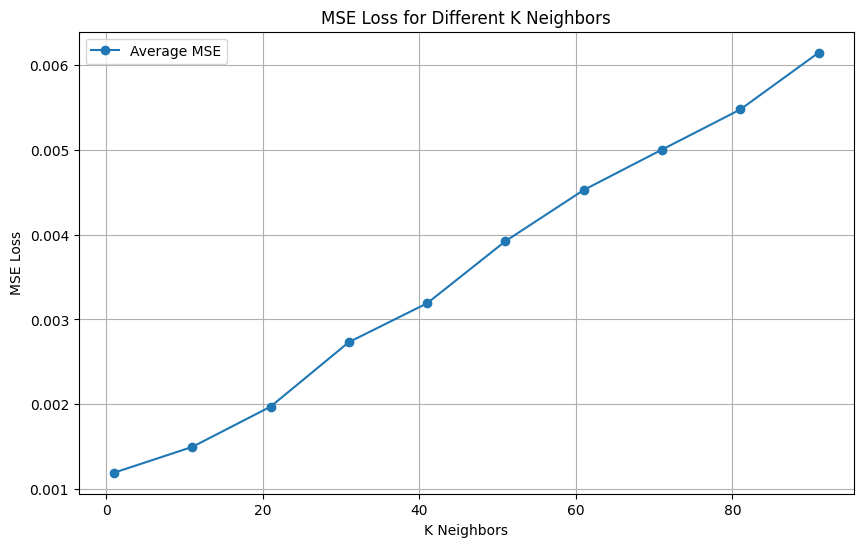

Last


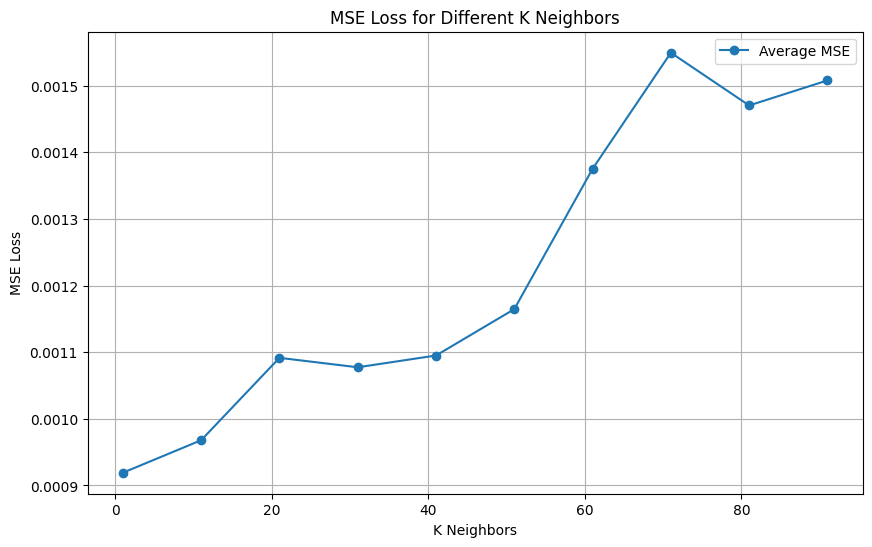

Random


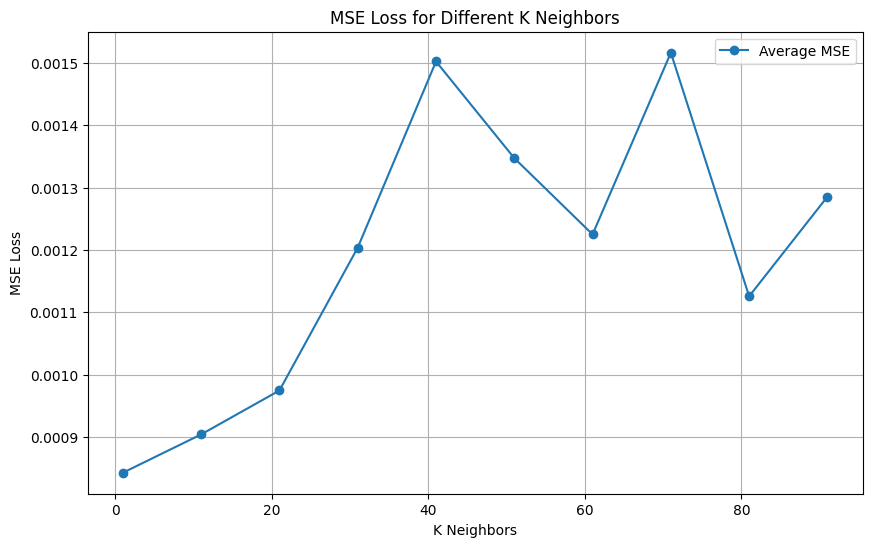

In [17]:
print("closest")
visualize_mse_results(mse_results["closest_mse"], list_of_indices, average=True)  # Visualize averaged results
print("Last")
visualize_mse_results(mse_results["last_mse"], list_of_indices, average=True)  # Visualize averaged results
print("Random")
visualize_mse_results(mse_results["random_mse"], list_of_indices, average=True)  # Visualize averaged results